#This notebook will help you walk through the UMAP + GMM implementation on fbref data.


Created By - Harsh Mishra (Twitter: @simplywink)

---



Thanks to Tony (Twitter: @TonyElHabr) for the inspiration. 
If you want to read more on the used approach, it is well explained in Tony's blog.
https://tonyelhabr.rbind.io/posts/dimensionality-reduction-and-clustering/


Links to understand UMAP:

https://youtu.be/qcLJ_JO6bn8

https://youtu.be/6BPl81wGGP8

https://youtu.be/OpZqfGXVB5U

https://umap-learn.readthedocs.io/en/latest/basic_usage.html

Links to understand GMM:

https://youtu.be/q71Niz856KE

https://youtu.be/WsGNJYCxwNM

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

Import packages.

In [ ]:
import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

from plotnine import *
!pip install umap-learn
import math
import itertools  
from numpy import linalg

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sklearn

from sklearn.model_selection import StratifiedKFold
from six import StringIO
from sklearn import mixture

import umap
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Load dataset

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/harshm16/FBref-2021-T5/main/FBRef%202020-21%20T5%20League%20Data%20-%20full.csv')

data.head()

,Player,Nation,Position,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,SoT%,Gls/Shot,Gls/SoT,AvgShotDist,FKSht/90,npxG/Shot,np:G-xG,PassCmp/90,PassAtt/90,PassCmp%,TotDistPass/90,PrgDistPass/90,ShortCmp/90,ShortAtt/90,ShortCmp%,MedCmp/90,MedAtt/90,MedCmp%,LongCmp/90,LongAtt/90,...,SuccPress/90,PressSucc%,Def 3rdPress/90,Mid 3rdPress/90,Att 3rdPress/90,Blocks/90,ShotBlocks/90,PassBlk/90,Interceptions/90,Clearances/90,ErrToShot/90,Touches/90,Def PenTchs/90,Def 3rdTchs/90,Mid 3rdTchs/90,Att 3rdTchs/90,Att PenTchs/90,%TchsDefPen,%TchsDefThrd,%TchsMidThrd,%TchsAttThrd,%TchsAttPen,LiveTchs/90,SuccDrib/90,AttDrib/90,DribSucc%,PlayersDribPast/90,Megs/90,Carries/90,TotDistCarry/90,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,Ismael Aaneba,fr FRA,Right-Back,"FW,DF",Strasbourg,fr Ligue 1,21.0,1999.0,2,0,11,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,20.0,20.0,100.0,570.0,150.0,0.00,0.00,NaN,10.00,10.00,100.0,10.00,10.00,...,0.00,0.0,10.00,10.00,0.00,0.00,0.00,0.00,0.00,20.00,0.0,40.0,20.00,40.00,10.0,0.0,0.00,0.500000,1.000000,0.250000,0.000000,0.000000,40.0,0.00,0.00,NaN,0.00,0.0,20.0,100.0,40.0,0.00,0.00,0.00,0.00,0.00,30.0,10.0,33.3,0.00
1,Patrik Schick,cz CZE,Centre-Forward,FW,Leverkusen,de Bundesliga,24.0,1996.0,29,20,"1,866",20.7,0.05,0.43,0.48,0.11,0.47,0.58,2.75,1.11,40.4,0.16,0.39,11.3,0.05,0.17,-0.03,15.0,20.8,72.3,208.9,28.6,8.70,11.30,76.9,4.54,6.43,70.7,0.72,1.01,...,2.90,26.4,0.24,4.15,6.57,0.48,0.29,0.19,0.10,0.82,0.0,31.8,1.16,1.88,15.7,15.5,5.70,0.036478,0.059119,0.493711,0.487421,0.179245,30.3,1.21,1.84,65.8,1.26,0.1,16.7,69.4,28.7,1.40,0.43,0.68,2.85,1.40,48.0,24.1,50.3,8.79
2,Issah Abbas,gh GHA,Centre-Forward,"DF,FW",Mainz 05,de Bundesliga,21.0,1998.0,2,0,18,0.2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,65.0,75.0,86.7,1300.0,530.0,30.00,35.00,85.7,25.00,30.00,83.3,10.00,10.00,...,0.00,0.0,0.00,5.00,10.00,0.00,0.00,0.00,0.00,0.00,0.0,90.0,0.00,25.00,30.0,40.0,5.00,0.000000,0.277778,0.333333,0.444444,0.055556,75.0,5.00,10.00,50.0,10.00,0.0,55.0,235.0,200.0,10.00,5.00,0.00,0.00,5.00,60.0,55.0,91.7,10.00
3,Yunus Mallı,tr TUR,Attacking Midfield,MF,Wolfsburg,de Bundesliga,28.0,1992.0,1,1,58,0.6,0.00,0.00,0.00,0.22,0.00,0.22,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.00,18.3,21.7,84.6,340.0,103.3,6.67,6.67,100.0,10.00,11.70,85.7,1.67,3.33,...,0.00,0.0,0.00,1.67,3.33,0.00,0.00,0.00,0.00,0.00,0.0,33.3,0.00,5.00,23.3,11.7,1.67,0.000000,0.150150,0.699700,0.351351,0.050150,31.7,0.00,3.33,0.0,0.00,0.0,25.0,75.0,38.3,1.67,1.67,0.00,0.00,5.00,48.3,28.3,58.6,5.00
4,Sacha Boey,fr FRA,Right-Back,DF,Rennes,fr Ligue 1,19.0,2000.0,2,2,124,1.4,0.00,0.00,0.00,0.06,0.09,0.14,0.71,0.00,0.0,0.00,NaN,14.2,0.00,0.12,-0.07,54.3,63.6,85.4,1032.1,342.9,24.30,27.10,89.5,22.90,26.40,86.5,6.43,8.57,...,7.86,52.4,5.71,4.29,5.00,1.43,0.00,1.43,0.71,1.43,0.0,75.0,0.00,20.00,40.0,17.1,1.43,0.000000,0.266667,0.533333,0.228000,0.019067,62.1,0.00,1.43,0.0,0.71,0.0,40.0,97.9,43.6,1.43,0.00,0.00,2.14,1.43,45.7,42.9,93.8,1.43


Find the unique positions of players in the dataset

In [ ]:
data['Position'].unique()

array(['Right-Back', 'Centre-Forward', 'Attacking Midfield',
       'Central Midfield', 'Defensive Midfield', 'Centre-Back',
       'Left Winger', 'Left-Back', 'Second Striker', 'Right Winger',
       'Goalkeeper', 'Left Midfield', 'Right Midfield', 'attack',
       'midfield', 'Defender'], dtype=object)

Adding a color column to the dataset, which we will use to visualize the UMM output.

In [ ]:
color_list = []
for n in range(len(data)):
    if str(data['Position'][n]) == 'Left-Back' or str(data['Position'][n]) == 'Centre-Back' or str(data['Position'][n]) == 'Right-Back' or str(data['Position'][n]) == 'Defender' :
        #defenders -: Red
        color_list.append("Red")
    elif str(data['Position'][n]) == 'Goalkeeper':
        #GK -: "Black"
        color_list.append("Black")
    elif str(data['Position'][n]) == 'Defensive Midfield' or str(data['Position'][n]) == 'Attacking Midfield' or str(data['Position'][n]) == 'Right Midfield' or str(data['Position'][n]) == 'Central Midfield' or str(data['Position'][n]) == 'Left Midfield' or str(data['Position'][n]) == 'midfield':
        #Midfielders -: "Blue"
        color_list.append("Blue")
    elif str(data['Position'][n]) == 'Left Winger' or str(data['Position'][n]) == 'Second Striker' or str(data['Position'][n]) == 'attack' or str(data['Position'][n]) == 'Right Winger' or str(data['Position'][n]) == 'Centre-Forward':
        #Forwards -: "Green"
        color_list.append("Green")
    else:
        color_list.append("Null")
        
data['Color'] = color_list

data['Color'].unique()


array(['Red', 'Green', 'Blue', 'Black'], dtype=object)

Adding 0 in place of all blank cells in our dataset.

---

Adding a filter : Minimum minutes played should be greater than 900


In [ ]:
data = data.fillna(0)

data = data[data['90s'] >= 10]

data.reset_index(drop=True)

,Player,Nation,Position,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,SoT%,Gls/Shot,Gls/SoT,AvgShotDist,FKSht/90,npxG/Shot,np:G-xG,PassCmp/90,PassAtt/90,PassCmp%,TotDistPass/90,PrgDistPass/90,ShortCmp/90,ShortAtt/90,ShortCmp%,MedCmp/90,MedAtt/90,MedCmp%,LongCmp/90,LongAtt/90,...,PressSucc%,Def 3rdPress/90,Mid 3rdPress/90,Att 3rdPress/90,Blocks/90,ShotBlocks/90,PassBlk/90,Interceptions/90,Clearances/90,ErrToShot/90,Touches/90,Def PenTchs/90,Def 3rdTchs/90,Mid 3rdTchs/90,Att 3rdTchs/90,Att PenTchs/90,%TchsDefPen,%TchsDefThrd,%TchsMidThrd,%TchsAttThrd,%TchsAttPen,LiveTchs/90,SuccDrib/90,AttDrib/90,DribSucc%,PlayersDribPast/90,Megs/90,Carries/90,TotDistCarry/90,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90,Color
0,Patrik Schick,cz CZE,Centre-Forward,FW,Leverkusen,de Bundesliga,24.0,1996.0,29,20,"1,866",20.7,0.05,0.43,0.48,0.11,0.47,0.58,2.75,1.11,40.4,0.16,0.39,11.3,0.05,0.17,-0.03,15.0,20.8,72.3,208.9,28.6,8.70,11.3,76.9,4.54,6.43,70.7,0.72,1.01,...,26.4,0.24,4.15,6.57,0.48,0.29,0.19,0.10,0.82,0.00,31.8,1.16,1.88,15.7,15.50,5.70,0.036478,0.059119,0.493711,0.487421,0.179245,30.3,1.21,1.84,65.8,1.26,0.10,16.7,69.4,28.7,1.40,0.43,0.68,2.85,1.40,48.0,24.1,50.3,8.79,Green
1,Mehdi Abeid,dz ALG,Central Midfield,MF,Nantes,fr Ligue 1,27.0,1992.0,18,15,"1,320",14.7,0.00,0.00,0.00,0.05,0.07,0.12,1.36,0.00,0.0,0.00,0.00,22.9,0.07,0.05,-0.07,41.9,49.3,85.0,829.5,200.7,16.80,17.9,93.9,17.00,19.30,88.0,7.01,10.50,...,34.7,5.10,9.05,2.52,1.22,0.14,1.09,1.56,0.95,0.07,59.3,1.77,15.20,37.5,11.80,0.88,0.029848,0.256324,0.632378,0.198988,0.014840,56.1,1.56,2.18,71.9,1.56,0.00,40.5,237.1,114.9,4.08,1.50,0.07,0.41,1.22,42.7,38.4,90.0,0.95,Blue
2,Laurent Abergel,fr FRA,Defensive Midfield,MF,Lorient,fr Ligue 1,27.0,1993.0,38,32,"2,963",32.9,0.03,0.09,0.12,0.04,0.04,0.08,0.91,0.30,33.3,0.10,0.30,25.9,0.00,0.04,0.05,40.4,48.4,83.5,785.3,198.2,16.10,18.3,87.9,17.50,19.40,90.0,6.08,8.78,...,28.1,9.82,16.40,2.92,1.55,0.18,1.37,1.40,0.40,0.00,60.0,1.22,15.60,38.6,9.39,0.52,0.020333,0.260000,0.643333,0.156500,0.008667,58.7,0.67,0.94,71.0,0.67,0.00,41.4,176.1,87.9,3.25,1.03,0.09,1.25,1.40,43.4,40.2,92.6,1.43,Blue
3,Charles Abi,fr FRA,Centre-Forward,"FW,MF",Saint-Étienne,fr Ligue 1,20.0,2000.0,24,9,912,10.1,0.20,0.30,0.49,0.03,0.21,0.24,1.88,0.40,21.1,0.16,0.75,11.8,0.00,0.11,0.09,14.3,21.2,67.3,188.0,33.1,8.32,10.8,77.1,3.66,5.15,71.2,0.59,1.98,...,25.4,2.38,10.50,9.31,0.69,0.10,0.59,0.69,0.59,0.00,34.2,0.89,4.06,16.3,15.60,4.36,0.026023,0.118713,0.476608,0.456140,0.127485,32.7,1.19,2.67,44.4,1.39,0.00,20.7,95.8,49.9,2.67,1.09,0.40,3.47,2.48,48.7,25.0,51.4,6.53,Green
4,Pape Cheikh Diop,sn SEN,Central Midfield,MF,Dijon,fr Ligue 1,22.0,1997.0,21,13,"1,089",12.1,0.00,0.00,0.00,0.06,0.03,0.09,0.50,0.00,0.0,0.00,0.00,19.6,0.00,0.07,-0.03,44.2,50.6,87.4,831.0,177.9,16.60,19.2,86.6,21.70,23.10,93.6,5.12,7.02,...,29.3,6.03,9.01,2.73,1.49,0.25,1.24,0.50,0.91,0.00,58.8,2.31,17.60,38.2,7.19,0.41,0.039286,0.299320,0.649660,0.122279,0.006973,57.9,0.83,1.24,66.7,0.91,0.00,40.2,217.9,122.8,4.21,0.58,0.08,0.66,1.16,44.6,41.6,93.1,0.66,Blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,Kurt Zouma,fr FRA,Centre-Back,DF,Chelsea,eng Premier League,25.0,1994.0,24,22,"2,029",22.5,0.00,0.22,0.22,0.00,0.08,0.08,1.20,0.53,44.4,0.19,0.42,12.2,0.00,0.07,0.14,70.2,76.4,91.9,1511.4,393.9,19.40,20.3,95.4,39.10,41.10,95.1,11.30,14.20,...,36.7,2.31,2.36,0.18,1.02,0.53,0.49,1.16,5.73,0.09,86.9,12.40,44.40,45.7,3.33,1.38,0.142693,0.510932,0.525892,0.038320,0.015880,85.7,0.22,0.31,71.4,0.22,0.00,59.5,312.4,182.6,4.31,0.98,0.00,0.18,0.31,68.0,66.9,9

In the above provided link to Tony's blog, he has included Goal Keepers in his analysis. Just as a personal perference, I will not include them in this analysis.

In [ ]:
data = data[data['Position'] != 'Goalkeeper']

data.reset_index(drop=True)


,Player,Nation,Position,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,SoT%,Gls/Shot,Gls/SoT,AvgShotDist,FKSht/90,npxG/Shot,np:G-xG,PassCmp/90,PassAtt/90,PassCmp%,TotDistPass/90,PrgDistPass/90,ShortCmp/90,ShortAtt/90,ShortCmp%,MedCmp/90,MedAtt/90,MedCmp%,LongCmp/90,LongAtt/90,...,PressSucc%,Def 3rdPress/90,Mid 3rdPress/90,Att 3rdPress/90,Blocks/90,ShotBlocks/90,PassBlk/90,Interceptions/90,Clearances/90,ErrToShot/90,Touches/90,Def PenTchs/90,Def 3rdTchs/90,Mid 3rdTchs/90,Att 3rdTchs/90,Att PenTchs/90,%TchsDefPen,%TchsDefThrd,%TchsMidThrd,%TchsAttThrd,%TchsAttPen,LiveTchs/90,SuccDrib/90,AttDrib/90,DribSucc%,PlayersDribPast/90,Megs/90,Carries/90,TotDistCarry/90,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90,Color
0,Patrik Schick,cz CZE,Centre-Forward,FW,Leverkusen,de Bundesliga,24.0,1996.0,29,20,"1,866",20.7,0.05,0.43,0.48,0.11,0.47,0.58,2.75,1.11,40.4,0.16,0.39,11.3,0.05,0.17,-0.03,15.0,20.8,72.3,208.9,28.6,8.70,11.3,76.9,4.54,6.43,70.7,0.72,1.01,...,26.4,0.24,4.15,6.57,0.48,0.29,0.19,0.10,0.82,0.00,31.8,1.16,1.88,15.7,15.50,5.70,0.036478,0.059119,0.493711,0.487421,0.179245,30.3,1.21,1.84,65.8,1.26,0.10,16.7,69.4,28.7,1.40,0.43,0.68,2.85,1.40,48.0,24.1,50.3,8.79,Green
1,Mehdi Abeid,dz ALG,Central Midfield,MF,Nantes,fr Ligue 1,27.0,1992.0,18,15,"1,320",14.7,0.00,0.00,0.00,0.05,0.07,0.12,1.36,0.00,0.0,0.00,0.00,22.9,0.07,0.05,-0.07,41.9,49.3,85.0,829.5,200.7,16.80,17.9,93.9,17.00,19.30,88.0,7.01,10.50,...,34.7,5.10,9.05,2.52,1.22,0.14,1.09,1.56,0.95,0.07,59.3,1.77,15.20,37.5,11.80,0.88,0.029848,0.256324,0.632378,0.198988,0.014840,56.1,1.56,2.18,71.9,1.56,0.00,40.5,237.1,114.9,4.08,1.50,0.07,0.41,1.22,42.7,38.4,90.0,0.95,Blue
2,Laurent Abergel,fr FRA,Defensive Midfield,MF,Lorient,fr Ligue 1,27.0,1993.0,38,32,"2,963",32.9,0.03,0.09,0.12,0.04,0.04,0.08,0.91,0.30,33.3,0.10,0.30,25.9,0.00,0.04,0.05,40.4,48.4,83.5,785.3,198.2,16.10,18.3,87.9,17.50,19.40,90.0,6.08,8.78,...,28.1,9.82,16.40,2.92,1.55,0.18,1.37,1.40,0.40,0.00,60.0,1.22,15.60,38.6,9.39,0.52,0.020333,0.260000,0.643333,0.156500,0.008667,58.7,0.67,0.94,71.0,0.67,0.00,41.4,176.1,87.9,3.25,1.03,0.09,1.25,1.40,43.4,40.2,92.6,1.43,Blue
3,Charles Abi,fr FRA,Centre-Forward,"FW,MF",Saint-Étienne,fr Ligue 1,20.0,2000.0,24,9,912,10.1,0.20,0.30,0.49,0.03,0.21,0.24,1.88,0.40,21.1,0.16,0.75,11.8,0.00,0.11,0.09,14.3,21.2,67.3,188.0,33.1,8.32,10.8,77.1,3.66,5.15,71.2,0.59,1.98,...,25.4,2.38,10.50,9.31,0.69,0.10,0.59,0.69,0.59,0.00,34.2,0.89,4.06,16.3,15.60,4.36,0.026023,0.118713,0.476608,0.456140,0.127485,32.7,1.19,2.67,44.4,1.39,0.00,20.7,95.8,49.9,2.67,1.09,0.40,3.47,2.48,48.7,25.0,51.4,6.53,Green
4,Pape Cheikh Diop,sn SEN,Central Midfield,MF,Dijon,fr Ligue 1,22.0,1997.0,21,13,"1,089",12.1,0.00,0.00,0.00,0.06,0.03,0.09,0.50,0.00,0.0,0.00,0.00,19.6,0.00,0.07,-0.03,44.2,50.6,87.4,831.0,177.9,16.60,19.2,86.6,21.70,23.10,93.6,5.12,7.02,...,29.3,6.03,9.01,2.73,1.49,0.25,1.24,0.50,0.91,0.00,58.8,2.31,17.60,38.2,7.19,0.41,0.039286,0.299320,0.649660,0.122279,0.006973,57.9,0.83,1.24,66.7,0.91,0.00,40.2,217.9,122.8,4.21,0.58,0.08,0.66,1.16,44.6,41.6,93.1,0.66,Blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,Kurt Zouma,fr FRA,Centre-Back,DF,Chelsea,eng Premier League,25.0,1994.0,24,22,"2,029",22.5,0.00,0.22,0.22,0.00,0.08,0.08,1.20,0.53,44.4,0.19,0.42,12.2,0.00,0.07,0.14,70.2,76.4,91.9,1511.4,393.9,19.40,20.3,95.4,39.10,41.10,95.1,11.30,14.20,...,36.7,2.31,2.36,0.18,1.02,0.53,0.49,1.16,5.73,0.09,86.9,12.40,44.40,45.7,3.33,1.38,0.142693,0.510932,0.525892,0.038320,0.015880,85.7,0.22,0.31,71.4,0.22,0.00,59.5,312.4,182.6,4.31,0.98,0.00,0.18,0.31,68.0,66.9,9

All the different statistics will be provided as the features for UMAP

In [ ]:
all_features = list(data.columns)
features = all_features[11:-1]

print(features)

['90s', 'Ast/90', 'npG/90', 'npG+A/90', 'xA/90', 'npxG/90', 'npxG+xA/90', 'Shots/90', 'SoTs/90', 'SoT%', 'Gls/Shot', 'Gls/SoT', 'AvgShotDist', 'FKSht/90', 'npxG/Shot', 'np:G-xG', 'PassCmp/90', 'PassAtt/90', 'PassCmp%', 'TotDistPass/90', 'PrgDistPass/90', 'ShortCmp/90', 'ShortAtt/90', 'ShortCmp%', 'MedCmp/90', 'MedAtt/90', 'MedCmp%', 'LongCmp/90', 'LongAtt/90', 'LongCmp%', 'KeyPass/90', 'PassIntoThird/90', 'PassIntoBox/90', 'CrossIntoBox/90', 'ProgPass/90', 'LivePassAtt/90', 'DeadPassAtt/90', 'FKPassAtt/90', 'TBCmp/90', 'PassUnderPress/90', 'Switches/90', 'Crosses/90', 'GroundPass/90', 'LowPass/90', 'HighPass/90', 'LeftPass/90', 'RightPass/90', 'HeadPass/90', 'ThrowPass/90', 'OtherPartPass/90', 'OffsidePass/90', 'OutOBPass/90', 'PassesInt/90', 'PassesBlk/90', 'SCA/90', 'PassLiveSCA/90', 'PassDeadSCA/90', 'DribSCA/90', 'ShSCA/90', 'FoulSCA/90', 'DefSCA/90', 'GCA/90', 'PassLiveGCA/90', 'PassDeadGCA/90', 'DribGCA/90', 'ShGCA/90', 'FoulGCA/90', 'DefGCA/90', 'TklAtt/90', 'TklW/90', 'Def 3rdT

Using z scores to scale the data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

X = data[features]

z = StandardScaler()

X[features] = z.fit_transform(X)

In [ ]:
X

,90s,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,SoT%,Gls/Shot,Gls/SoT,AvgShotDist,FKSht/90,npxG/Shot,np:G-xG,PassCmp/90,PassAtt/90,PassCmp%,TotDistPass/90,PrgDistPass/90,ShortCmp/90,ShortAtt/90,ShortCmp%,MedCmp/90,MedAtt/90,MedCmp%,LongCmp/90,LongAtt/90,LongCmp%,KeyPass/90,PassIntoThird/90,PassIntoBox/90,CrossIntoBox/90,ProgPass/90,LivePassAtt/90,DeadPassAtt/90,FKPassAtt/90,TBCmp/90,PassUnderPress/90,...,SuccPress/90,PressSucc%,Def 3rdPress/90,Mid 3rdPress/90,Att 3rdPress/90,Blocks/90,ShotBlocks/90,PassBlk/90,Interceptions/90,Clearances/90,ErrToShot/90,Touches/90,Def PenTchs/90,Def 3rdTchs/90,Mid 3rdTchs/90,Att 3rdTchs/90,Att PenTchs/90,%TchsDefPen,%TchsDefThrd,%TchsMidThrd,%TchsAttThrd,%TchsAttPen,LiveTchs/90,SuccDrib/90,AttDrib/90,DribSucc%,PlayersDribPast/90,Megs/90,Carries/90,TotDistCarry/90,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
1,-0.107285,-0.426235,2.006644,1.228193,0.248495,2.675624,2.032894,1.759499,1.897950,0.629803,0.797745,0.500057,-1.105234,0.016920,1.662473,-0.423869,-1.469564,-1.598364,-0.895061,-1.506408,-1.605079,-1.059160,-0.955897,-1.638477,-1.383206,-1.453195,-1.427237,-1.348783,-1.619774,0.738134,0.229966,-1.370358,-1.117782,-0.836342,-1.592107,-1.548395,-0.703256,-1.260541,-0.784910,0.443883,...,-0.968878,-0.728868,-2.048621,-0.767725,1.324915,-1.825839,-0.106566,-1.965580,-1.746745,-0.735957,-0.586037,-1.678555,-0.738361,-1.305986,-1.306874,0.044107,1.872714,-0.445090,-1.320621,-0.133584,1.144469,2.691275,-1.620264,0.296498,0.153447,0.203040,0.244455,0.350038,-1.688911,-1.686190,-1.665031,-1.284482,-1.022498,0.648428,1.738735,0.328531,0.182313,-1.150456,-2.289163,1.825446
5,-0.946306,-0.911290,-0.798029,-1.007874,-0.511500,-0.395402,-0.507369,0.209176,-1.051301,-2.036764,-1.044558,-1.112478,1.144325,0.192357,-0.885757,-0.973822,0.273066,0.173546,0.735413,0.326847,-0.112897,0.215441,0.049640,1.181145,0.076162,0.042090,0.520354,0.543600,0.527767,0.385774,-0.062454,0.745935,-0.503616,0.238348,-0.242782,0.223523,-0.146912,1.259506,-0.138288,-0.470414,...,1.131275,0.881462,0.179431,0.940301,-0.300280,-0.535700,-0.595613,-0.222119,0.795803,-0.668720,1.214406,0.106299,-0.547266,-0.146399,0.758266,-0.365089,-0.716210,-0.580115,-0.124047,1.624931,-0.477910,-0.647902,0.145711,0.742797,0.410892,0.569254,0.600825,-0.692936,0.299724,0.601281,0.232093,-0.049535,0.294837,-0.663536,-0.855766,0.110070,-0.272112,-0.001338,0.431472,-0.798890
6,1.598725,-0.620257,-0.211004,-0.448857,-0.638166,-0.625729,-0.728262,-0.292727,-0.254206,0.161173,0.106881,0.127934,1.726108,-0.421673,-1.098110,0.676037,0.175893,0.117591,0.542838,0.196280,-0.134573,0.105290,0.110582,0.185984,0.134724,0.053708,0.745510,0.263804,0.138539,0.565869,-0.339483,0.363826,-0.438967,-0.358702,0.086479,0.289887,-0.718052,0.034162,-0.230663,1.704423,...,2.881402,-0.399041,2.343301,3.502340,-0.139767,0.039632,-0.465201,0.320291,0.517168,-0.953185,-0.586037,0.151731,-0.719565,-0.111576,0.862471,-0.631619,-0.909574,-0.773900,-0.101741,1.763865,-0.716897,-0.773282,0.323678,-0.392079,-0.528025,0.515223,-0.456408,-0.692936,0.374924,-0.230774,-0.362134,-0.432000,-0.283806,-0.620520,0.037423,0.328531,-0.212094,0.143306,0.609649,-0.638217
7,-1.589556,1.028930,1.158720,1.274778,-0.764831,0.679457,0.155308,0.789153,0.011492,-0.644077,0.797745,1.988550,-1.008270,-0.421673,0.388358,1.225990,-1.514911,-1.573495,-1.536979,-1.568146,-1.566062,-1.118956,-1.032074,-1.605305,-1.486275,-1.601910,-1.370949,-1.387894,-1.400268,-2.503578,-0.108625,-1.129336,-0.471291,-0.836342,-1.385512,-1.521849,-0.691419,-1.260541,0.138835,0.595365,...,1.029184,-0.922883,-1.067545,1.445737,2.424429,-1.459719,-0.726026,-1.190708,-0.719277,-0.854915,-0.586037,-1.522786,-0.822945,-1.116204,-1.250035,0.055166,1.152972,-0.658013,-0.959024,-0.350471,0.968520,1.640000,-1.455987,0.270995,0.781916,-1.081710,0.398882,-0.692936,-1.354687,-1.326087,-1.198453,-0.699265,-0.209

UMAP model with 2 components, i.e. it brings down the size of the features to just 2 components

In [ ]:

fit = umap.UMAP(n_components=2)


Fitting the 2 component umap model on our features dataset

In [ ]:
u = fit.fit_transform(X)

The new Colors column that we added above comes in use in this cell.

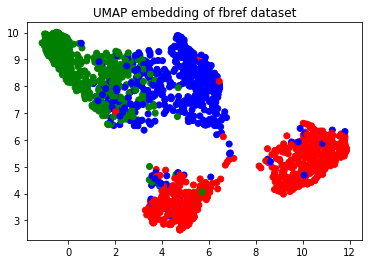

In [ ]:
plt.scatter(u[:,0], u[:,1], c=data['Color'])

plt.title('UMAP embedding of fbref dataset');


#defenders -: Red
   
#GK -: "Black"    #not found as we decided to remove them above

#Midfielders -: "Blue"

#Forwards -: "Green"

Fitting GMM on top of the UMAP components

Silhouette score: The best value is 1 and the worst value is -1

You may select different values for n_components, the best value according to Silhouette score seems to be 5, but I have chosen 6 in this notebook as I liked how the clusters in this particular run came off.

In [ ]:
EM = GaussianMixture(n_components = 6,covariance_type='full')

EM.fit(u)

cluster = EM.predict(u)     #cluster list contains all the cluster values for each player

cluster


cluster_p = EM.predict_proba(u)

cluster_p               #cluster_p list contains the probability of the player being assigned to each cluster

print("Silhouette score is",silhouette_score(u,cluster))


Silhouette score is 0.5244193


Adding the cluster list & cluster probability list to our dataframe

In [ ]:
data['cluster'] = cluster

cluster_prob = []

for n in range(len(cluster)):
    
    cluster_prob.append(cluster_p[n][cluster[n]])
    
data['cluster_prob'] = cluster_prob

Adding the UMAP components to the dataframe

In [ ]:
umap_1 = []
for n in range(len(u)):
    umap_1.append(u[n][0])
    
umap_2 = []
for n in range(len(u)):
    umap_2.append(u[n][1])
    
data['umap_1'] = umap_1
data['umap_2'] = umap_2

Function to plot the cluster alongwith it's ellipsoids

In [ ]:
#Color for each cluster, in case your selected number of clusters is greater than 6, you will need to add more colors to this list 
color_iter = ['navy', 'green', 'cornflowerblue', 'red','darkorange','purple']


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
 
        #plotting the dataset cluster wise
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], color=color,s=0.8,zorder=1)

        #to create the ellipsoid
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color,zorder=4)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        ell.set_zorder(4)
        splot.add_artist(ell)
        center_co = ell.get_center()
        plt.scatter(center_co[0],center_co[1],color=color,s=4) 
        
        #Needs to be manually edited based on each run, as the cluster numbers change each time you run the GMM code.
        if color == 'navy':
            plt.text (center_co[0]+1.5,center_co[1]+3.5,"ST",color=color)
            plt.plot((center_co[0],center_co[0]+1),(center_co[1],center_co[1]+3),color='black')
        elif color == "green":
            plt.plot((center_co[0],center_co[0]-1.6),(center_co[1],center_co[1]-1.8),color='black')
            plt.text (center_co[0]-2.5,center_co[1]-3.5,"CB",color=color)
        elif color == "cornflowerblue":
            plt.plot((center_co[0],center_co[0]-2),(center_co[1],center_co[1]-3),color='black')
            plt.text (center_co[0]-2.5,center_co[1]-4.5,"CM",color=color)
        elif color == 'red':
            plt.text (center_co[0]-1.5,center_co[1]-4,"FB",color=color)
            plt.plot((center_co[0],center_co[0]-1),(center_co[1],center_co[1]-2),color='black')
        elif color == 'darkorange':
            plt.text (center_co[0]-1.5,center_co[1]-4,"AM",color=color)
            plt.plot((center_co[0],center_co[0]-1),(center_co[1],center_co[1]-2),color='black')
        elif color == 'purple':
            plt.text (center_co[0]+1.5,center_co[1]+4,"CDM",color=color)
            plt.plot((center_co[0],center_co[0]+1),(center_co[1],center_co[1]+3),color='black')
        
    plt.xlim(-2., 15.5)
    plt.ylim(-5.,14.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.text(10.8,-3.8,"By- @simplywink")
    #plt.savefig('gmm_final.png',dpi=720,bbox_inches='tight')
    
#Based on this run:
#Position - Cluster Number

#ST - 0 - navy
#CB - 1 - green 
#CM - 2 - cornflowerblue
#FB = 3 - red
#AM - 4 - darkorange
#CDM -5 - purple

GMM viz using the above function

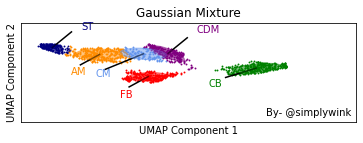

In [ ]:
plot_results(u, EM.predict(u), EM.means_, EM.covariances_, 0,
             'Gaussian Mixture')

Let's validate our clustering model on the basis of our footballing knowldege

In [ ]:
data[data['Squad'] == "Tottenham"][['Player','cluster','cluster_prob','Age','Squad']]

#All the attacker including Harry Kane! have been assigned to the 4th cluster (AM)

#Ndombele & Lo Celso assigned to cluster 2 (CM)

#Full backs assigned to cluster 3

#CBs assigned to cluster 1

#CDMs assigned to cluster 5

#No ones got assigned to the striker cluster, Kane & Son are too creative to be assigned to the Striker cluster!

,Player,cluster,cluster_prob,Age,Squad
82,Steven Bergwijn,4,0.982990,22.0,Tottenham
179,Gareth Bale,4,0.998917,31.0,Tottenham
580,Tanguy Ndombele,2,0.734083,23.0,Tottenham
631,Ben Davies,3,1.000000,27.0,Tottenham
713,Eric Dier,1,1.000000,26.0,Tottenham
740,Matt Doherty,3,1.000000,28.0,Tottenham
811,Serge Aurier,3,1.000000,27.0,Tottenham
1005,Pierre Højbjerg,5,0.957221,24.0,Tottenham
1282,Harry Kane,4,0.976235,27.0,Tottenham
1482,Giovani Lo Celso,2,0.953302,24.0,Tottenham


Let's find similar players based on their UMAP components

In [ ]:
player_name = "Jadon Sancho"

data_player = data[(data['Player'] == player_name)]

metrix = ['umap_1','umap_2','cluster']

player_data = []
for n in metrix:
    player_data.append(float(data_player[n]))

    
data[data['Player'] == player_name][['Player','cluster','cluster_prob','Age','Squad']]

,Player,cluster,cluster_prob,Age,Squad
1261,Jadon Sancho,4,0.999734,20.0,Dortmund


In [ ]:
distance = []
for n in range(len(cluster)):
    if (umap_1[n] == player_data[0]) and (umap_2[n] == player_data[1]):
        distance.append(10000)
    else:
        distance.append(math.sqrt((umap_1[n]-player_data[0])**2 + (umap_2[n] - player_data[1])**2))
        #print(math.sqrt((umap_1[n]-player_data[0])**2 + (umap_2[n] - player_data[1])**2)) 
    
data['distance'] = distance

data.sort_values(by=['distance'])

data['Rank'] = data['distance'].rank(ascending=True)

data.sort_values(by=['Rank'])[['Player','Rank','cluster','cluster_prob','Age','Squad']].head(10)

,Player,Rank,cluster,cluster_prob,Age,Squad
1255,Alexis Sánchez,1.0,4,0.999604,31.0,Inter
642,Callum Hudson-Odoi,2.0,4,0.999524,19.0,Chelsea
566,Jack Grealish,3.0,4,0.999703,24.0,Aston Villa
407,Riyad Mahrez,4.0,4,0.999574,29.0,Manchester City
1069,Ousmane Dembélé,5.0,4,0.999766,23.0,Barcelona
83,Leon Bailey,6.0,4,0.999413,22.0,Leverkusen
994,Pedro Neto,7.0,4,0.999354,20.0,Wolves
296,Kingsley Coman,8.0,4,0.999748,24.0,Bayern Munich
1038,Christopher Nkunku,9.0,4,0.999181,22.0,RB Leipzig
137,Hatem Ben Arfa,10.0,4,0.999126,33.0,Bordeaux


In [ ]:
data['Position'].unique()

array(['Centre-Forward', 'Central Midfield', 'Defensive Midfield',
       'Centre-Back', 'Left Winger', 'Left-Back', 'Second Striker',
       'Right-Back', 'Right Winger', 'Right Midfield',
       'Attacking Midfield', 'Left Midfield'], dtype=object)

Adding a new column to the dataframe in order to build a confusion matrix


---


In this new column, adjusted_position, we will manually assign each player position present in our dataset to what we think should be their respective cluster

In [ ]:
data = data.reset_index(drop=True)

data

adjusted_position = []

#copied from above
#ST - 0 - navy
#CB - 1 - green 
#CM - 2 - cornflowerblue
#FB = 3 - red
#AM - 4 - darkorange
#CDM -5 - purple

for n in range(len(data)):
    if str(data['Position'][n]) == 'Defensive Midfield':
        adjusted_position.append(5)   #change this number based on the cluster that they go into, "MAY CHANGE AFTER EACH GMM Run"
    elif str(data['Position'][n]) == 'Centre-Forward' or str(data['Position'][n]) == 'Second Striker':
        adjusted_position.append(0)   #change this number based on the cluster that they go into, "MAY CHANGE AFTER EACH GMM Run"
    elif str(data['Position'][n]) == 'Centre-Back':
        adjusted_position.append(1)   #change this number based on the cluster that they go into, "MAY CHANGE AFTER EACH GMM Run"
    elif str(data['Position'][n]) == 'Left-Back' or str(data['Position'][n]) == 'Right-Back':
        adjusted_position.append(3)   #change this number based on the cluster that they go into, "MAY CHANGE AFTER EACH GMM Run"
    elif str(data['Position'][n]) == 'Left Winger' or str(data['Position'][n]) == 'Right Winger'  or str(data['Position'][n]) == 'Attacking Midfield':
        adjusted_position.append(4)   #change this number based on the cluster that they go into, "MAY CHANGE AFTER EACH GMM Run"
    elif str(data['Position'][n]) == 'Right Midfield' or str(data['Position'][n]) == 'Left Midfield' or  str(data['Position'][n]) == 'Central Midfield':
        adjusted_position.append(2)   #change this number based on the cluster that they go into, "MAY CHANGE AFTER EACH GMM Run"


data['adjusted_position'] = adjusted_position


Building a confusion matrix

In [ ]:
cm = confusion_matrix(cluster,adjusted_position)

#Labels may change after each GMM run

#copied from above
#ST - 0 - navy
#CB - 1 - green 
#CM - 2 - cornflowerblue
#FB = 3 - red
#AM - 4 - darkorange
#CDM -5 - purple

labels = ['ST', 'CB', 'CM', 'FB', 'AM','CDM']

Function to create a confusion matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('Label in our dataset\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

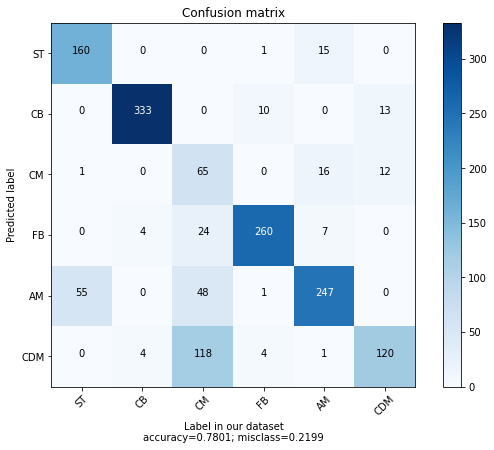

In [ ]:
#copied from above
#ST - 0 - navy
#CB - 1 - green 
#CM - 2 - cornflowerblue
#FB = 3 - red
#AM - 4 - darkorange
#CDM -5 - purple

plot_confusion_matrix(cm,labels,title='Confusion matrix',cmap=None,normalize=False)

#Confusion Matrix Analysis

1) 118 players who were labelled as CM (CM,LM & RM) in our data set, have been assigned as CDM by our model, some have even gone to FB (as they were LM & RM) & others to AM. This label has the lowest prediction accuracy, the way that CM, LM & RMs are used in general does justify the incorrect labelling.




In [ ]:
#For easy understanding, adjusted_position value will be the index matching the x axis (label in our dataset), 
#cluster value will be the index matching the y axis (Predicted label):


#CMs assigned as CDM:

data[(data['adjusted_position'] == 2) & (data['cluster'] == 5)][['Player','Rank','cluster','cluster_prob','adjusted_position','Age','Squad']].head(10)

#The names of Pape Cheikh Diop, Allan, Charles Aránguiz justify this classification

,Player,Rank,cluster,cluster_prob,adjusted_position,Age,Squad
1,Mehdi Abeid,768.0,5,0.884054,2,27.0,Nantes
4,Pape Cheikh Diop,852.0,5,0.920901,2,22.0,Dijon
13,Yan Brice Eteki,845.0,5,0.941095,2,22.0,Granada
25,Jean-Daniel Akpa-Akpro,835.0,5,0.931456,2,27.0,Lazio
35,Tolgay Arslan,809.0,5,0.909243,2,29.0,Udinese
41,Allan,1049.0,5,0.893881,2,29.0,Everton
61,Mauro Arambarri,694.0,5,0.772723,2,24.0,Getafe
62,Charles Aránguiz,995.0,5,0.948335,2,31.0,Leverkusen
111,Leandro Barreiro Martins,801.0,5,0.922960,2,20.0,Mainz 05
126,Rodrigo Bentancur,1027.0,5,0.967218,2,23.0,Juventus


In [ ]:
#CMs assigned as FB

data[(data['adjusted_position'] == 2) & (data['cluster'] == 3)][['Player','Rank','cluster','cluster_prob','adjusted_position','Age','Squad']]

#List mostly containing Wing backs, good classification

,Player,Rank,cluster,cluster_prob,adjusted_position,Age,Squad
51,Solly March,1016.0,3,1.000000,2,26.0,Brighton
55,Angeliño,735.0,3,0.999890,2,23.0,RB Leipzig
329,Lennart-Marten Czyborra,700.0,3,1.000000,2,21.0,Genoa
358,Jonathan Delaplace,866.0,3,1.000000,2,34.0,Lorient
464,Paolo Ghiglione,532.0,3,0.999979,2,23.0,Genoa
465,Davide Faraoni,937.0,3,1.000000,2,28.0,Hellas Verona
466,Mohamed Fares,540.0,3,0.999969,2,24.0,Lazio
482,Salvatore Molina,585.0,3,0.999994,2,28.0,Crotone
602,Achraf Hakimi,577.0,3,0.999893,2,21.0,Inter
685,Marco John,879.0,3,1.000000,2,18.0,Hoffenheim


In [ ]:
#CMs assigned as AM

data[(data['adjusted_position'] == 2) & (data['cluster'] == 4)][['Player','Rank','cluster','cluster_prob','adjusted_position','Age','Squad']].head(5)

#This list has CMs with high creativity, or left & right mids who played as wingers

,Player,Rank,cluster,cluster_prob,adjusted_position,Age,Squad
17,Ruben Loftus-Cheek,242.0,4,0.960374,2,24.0,Fulham
30,Luis Alberto,185.0,4,0.962463,2,27.0,Lazio
31,Marc Albrighton,246.0,4,0.800110,2,30.0,Leicester City
36,Carles Aleñá,291.0,4,0.678525,2,22.0,Getafe
58,Houssem Aouar,50.0,4,0.998738,2,22.0,Lyon



2) 55 Strikers (FW & SS) have been assigned as AM, Harry Kane being one of them. My assumption is that most of these 55 provide a lot of creativity as well.


In [ ]:
#Forwards/Second Strikers assigned as AM

data[(data['adjusted_position'] == 0) & (data['cluster'] == 4)][['Player','Rank','cluster','cluster_prob','adjusted_position','Age','Squad']]

#This list has Striker who provide creativity as well & are not just out & out goal scorers.

,Player,Rank,cluster,cluster_prob,adjusted_position,Age,Squad
10,Tyler Roberts,305.0,4,0.987704,0,21.0,Leeds United
48,Wissam Ben Yedder,198.0,4,0.558813,0,29.0,Monaco
70,Iago Aspas,62.0,4,0.994204,0,32.0,Celta Vigo
77,Jordan Ayew,300.0,4,0.941741,0,28.0,Crystal Palace
114,Musa Barrow,121.0,4,0.998459,0,21.0,Bologna
150,Karim Benzema,177.0,4,0.767370,0,32.0,Real Madrid
188,Lucas Boyé,404.0,4,0.611762,0,24.0,Elche
210,Jonathan Burkardt,311.0,4,0.996895,0,20.0,Mainz 05
273,Gaëtan Charbonnier,187.0,4,0.998473,0,31.0,Brest
306,Ángel Correa,151.0,4,0.977253,0,25.0,Atlético Madrid


#Confusion Matrix Analysis

3) 4 Full backs have been assigned as CDMs (Guariola Full backs)

In [ ]:
#Full backs as CDMs

data[(data['adjusted_position'] == 3) & (data['cluster'] == 5)][['Player','Rank','cluster','cluster_prob','adjusted_position','Age','Squad']]

#Manchester City!!

,Player,Rank,cluster,cluster_prob,adjusted_position,Age,Squad
21,Oleksandr Zinchenko,1155.0,5,0.704393,3,23.0,Manchester City
604,Marcel Halstenberg,1157.0,5,0.904945,3,28.0,RB Leipzig
1370,Kenny Tete,1092.0,5,0.888546,3,24.0,Fulham
1459,Kyle Walker,1109.0,5,0.989171,3,30.0,Manchester City


#Confusion Matrix Outliers

1) There is a full back in our data set who has been assigned as Striker by our model!



In [ ]:
#Full back as Striker:

data[(data['adjusted_position'] == 3) & (data['cluster'] == 0)][['Player','Rank','cluster','cluster_prob','adjusted_position','Age','Squad']]

#If you search his name on fbref, you'll find out that most of his detailed stats are missing!



,Player,Rank,cluster,cluster_prob,adjusted_position,Age,Squad
138,Salvador Ferrer,601.0,0,0.999541,3,22.0,Spezia


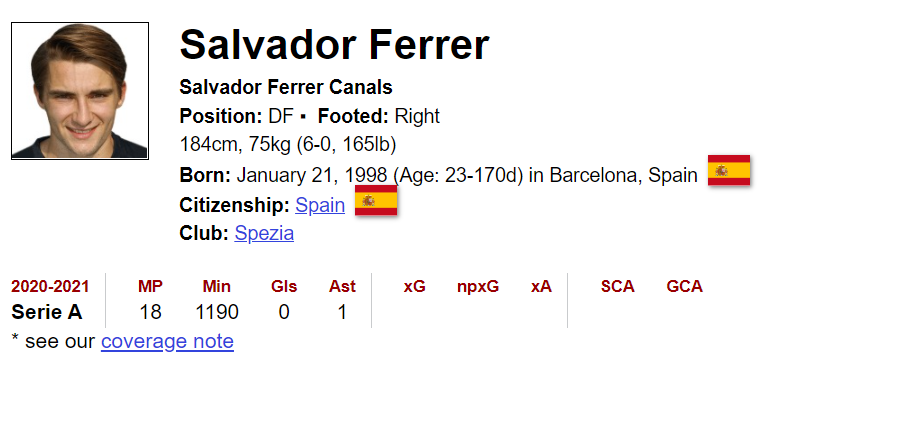

2) There is another full back who has been assigned as AM.


In [ ]:
#Full backs characterized as AMs

data[(data['adjusted_position'] == 3) & (data['cluster'] == 4)][['Player','Rank','cluster','cluster_prob','adjusted_position','Age','Squad']]

#We all have just seen it in the Euros!!

,Player,Rank,cluster,cluster_prob,adjusted_position,Age,Squad
1332,Leonardo Spinazzola,31.0,4,0.997848,3,27.0,Roma


3) A Striker has been assinged as CM

In [ ]:
#Striker as CM

data[(data['adjusted_position'] == 0) & (data['cluster'] == 2)][['Player','Rank','cluster','cluster_prob','adjusted_position','Age','Squad']]

#Just about made the > 10 90s played cut, No clue really, probably his passing numbers outweigh his shooting/creation!?

,Player,Rank,cluster,cluster_prob,adjusted_position,Age,Squad
913,Papu Gómez,501.0,2,0.94081,0,32.0,Sevilla


#Note

1) The cluster numbers may change after each run, the way the clusters are formed may change as well.

2) The manual assignments of clusters to each position is needed to be done after each run. As pointed out in Tony's blog matching and correlations can be used to do that, but that has not yet been implemented in this notebook.

3) You can see the probability of players being assigned to each cluster groups. Just pass different cluster numbers to the list cluster_p to get probability of that player being assigned to each cluster

#Conclusion:

The soft assignment used by GMMs really benefits us in identifying players who have played mutliple positions (i.e. have a set of statistics matching that of multiple positions). Rather than saying that player X is a forward, we can now say that player X has Y % probabilty of being in the Forwards cluster & Z % probability of being in the Attacking Midfielders cluster.